In [1]:
from PIL import Image
import os
import random
import torch
from torch.utils.data  import Dataset, DataLoader
from torchvision import transforms
to_tensor = transforms.ToTensor()
to_img = transforms.ToPILImage()

In [2]:
from unet import UNet

In [3]:
def resize_img(img,max_width = 400):
    w,h = img.size
    max_height = int(h / w * max_width)
    img = img.resize((max_width,max_height),Image.ANTIALIAS)
    return img

def get_random_pos(big_box,small_box):
    bw,bh = big_box
    sw,sh = small_box
    x = random.randrange(0,bw-sw)
    y = random.randrange(0,bh-sh)
    return(x,y)

class myDataset(Dataset):
    def __init__(self, n = 10,path_org = 'data/pictures', path_wm = 'data/watermarks',path_out = "data/out",gen=False):
        super().__init__()
        self.n = n
        self.path_org = path_org
        self.path_wm = path_wm
        self.path_out = path_out
        self.gen = gen
        self.imglist= [x for x in os.listdir(self.path_org) if x.endswith('.jpeg')]
        self.imglist_size = len(self.imglist)
        self.wmlist = [x for x in os.listdir(self.path_wm) if x.endswith('.png')]
        self.wmlist_size = len(self.wmlist)
        
    def __len__(self):
        return self.n
       
    def __getitem__(self,idx):
        ix = random.randrange(0,self.imglist_size)
        iwm = random.randrange(0,self.wmlist_size)

        img = Image.open(os.path.join(self.path_org,self.imglist[ix])).convert("RGB")
        img = resize_img(img)
        imgwm = Image.open(os.path.join(self.path_wm,self.wmlist[iwm]))
        imgwm = imgwm if imgwm.size[0] <150 else resize_img(imgwm,random.randrange(100,150))
        imgwm = imgwm.convert("RGBA")
        r,g,b,a = imgwm.split()

        x,y = get_random_pos(img.size,(200,200))
        img = img.crop((x,y,x+200,y+200))

        target = Image.new("RGBA",(200,200),(0,0,0,0))
        target.paste(img,(0,0))

        x,y = get_random_pos((200,200),imgwm.size)
        target.paste(imgwm,(x,y),a)
        target = target.convert("RGB")

        if self.gen:
            target.save(os.path.join(self.path_out,str(idx) + ".png"))
            out =  {"src":img, "wm":target}
        else:
            src_t = to_tensor(img)
            wm_t = to_tensor(target)
            out = {"src_t":src_t, "wm_t":wm_t}
        return out

In [4]:
train_ds  = myDataset(n = 20)
val_ds = myDataset(n = 10)
train_dl =DataLoader(train_ds,batch_size=2)
val_dl = DataLoader(val_ds, batch_size=2)

In [49]:
class myModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.p = torch.nn.Parameter(torch.rand(1))
    def forward(self,x):
        return self.p *x
        
#model = myModel()
model = UNet(3,3)
optim = torch.optim.RMSprop(model.parameters(),lr=1e-4)

In [50]:
#loss_func = torch.nn.L1Loss()
#loss_func = torch.nn.MSELoss()
def loss_func(x,y):
    d = torch.abs(x - y)
    z  = torch.min(x,y)
    d = d /(1+z)
    return torch.mean(d)

In [76]:
for i,x in enumerate(train_dl):
    src_t = x['src_t']
    wm_t = x['wm_t']
    out = model(wm_t)
    loss = loss_func(out,src_t)
    print(f"{i},loss={loss.data}")
    optim.zero_grad()
    loss.backward()
    optim.step()
    

0,loss=0.013102794997394085
1,loss=0.009990779682993889
2,loss=0.0209365114569664
3,loss=0.03447923809289932
4,loss=0.015571297146379948
5,loss=0.028717251494526863
6,loss=0.04270811378955841
7,loss=0.03908628597855568
8,loss=0.02315344102680683
9,loss=0.0220375694334507


# end

In [75]:
optim.param_groups[0]['lr'] = 1e-5

In [ ]:
xx = myDataset(n=10,gen=True)

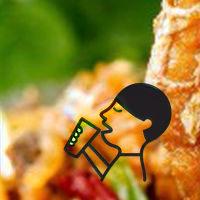

In [73]:
to_img(model(train_ds[0]['wm_t'].unsqueeze(0)).squeeze(0))